Lateness Report [link](https://gttwiki.atlassian.net/wiki/spaces/GD/pages/2492956684/Lateness+report)

Approach 2 (compare time late for the last stop for TSPon vs TSPoff)

In [1]:
import pandas as pd
import os
from data_preparation import prepare_triplogs, prepare_tripdatas, get_clean_triplogs, get_clean_tripdatas
import matplotlib.pyplot as plt

In [2]:
data_dir = "../2020_11_8_to_2020_11_14"

In [3]:
!ls ../2020_11_8_to_2020_11_14/CMS

intersectionstatusreport.csv
intersectionstatusreport_data_dictionary.docx
opticomdevicelog.csv
opticomdevicelog_data_dictonary.docx


In [4]:
tripdatas_df = pd.read_csv(os.path.join(data_dir, "CVP/tripdatas.csv"))

In [5]:
triplogs_df = pd.read_csv(os.path.join(data_dir, "CVP/triplogs.csv"))

In [6]:
triplogs_df = prepare_triplogs(triplogs_df)
tripdatas_df = prepare_tripdatas(tripdatas_df)

# takes about 10 minutes to run

tripdatas_df = get_clean_tripdatas(tripdatas_df) # cleaning tripdatas first is important
tripdatas_df_good = tripdatas_df[tripdatas_df["is_good_for_study"]]
triplogs_df = get_clean_triplogs(triplogs_df, tripdatas_df_good)
triplogs_df_good = triplogs_df[triplogs_df["is_good_for_study"]]

drop invalid
drop starttime >= endtime
drop endstatus not completed
drop normal tspmode
drop negative duration
drop <=70% stops hit
drop <=70% breadcrumbs
drop duplicated rows
drop tspon no tsp requests
drop 3 stds anomalies


## Whole trip

In [7]:
import numpy as np
triplogs_on = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOn'].groupby(['routename', 'direction','stops'])['countlate'].apply(list)
triplogs_on = triplogs_on.apply(lambda x: np.array(x))

In [8]:
triplogs_off = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOff'].groupby(['routename', 'direction','stops'])['countlate'].apply(list)
triplogs_off = triplogs_off.apply(lambda x: np.array(x))

In [9]:
# drop less that 3 obserations
triplogs_off_idx = triplogs_off.apply(lambda x: len(x) > 3)
triplogs_off = triplogs_off[triplogs_off_idx]
print(triplogs_off.shape)

triplogs_on_idx = triplogs_on.apply(lambda x: len(x) > 3)
triplogs_on = triplogs_on[triplogs_on_idx]


print(triplogs_on.shape)

(78,)
(52,)


In [10]:
from scipy import stats
# mann-whitney u-test
def mannwhitney(triplogs_on, triplogs_off):
    rejected = []
    num_errors = 0
    for idx in triplogs_on.index:
        if idx in triplogs_off.index:
            try:
                pval = stats.mannwhitneyu(triplogs_on[idx], triplogs_off[idx], alternative='less').pvalue
                if pval < 0.05:
                    pass
                    #print(idx, f'route is significally faster with pval {pval:.2f}')
                rejected.append(
                    (pval, idx)
                )
            except ValueError:
                num_errors += 1
            
    print(len(rejected), 'of', len(triplogs_on.index), 'rejected', len(rejected)/len(triplogs_on.index))
    return rejected, num_errors

In [11]:
# student two samples t-test
def student(triplogs_on, triplogs_off):
    rejected = []
    num_errors = 0
    for idx in triplogs_on.index:
        if idx in triplogs_off.index:   
            pval = stats.ttest_ind(triplogs_on[idx], triplogs_off[idx], alternative='less').pvalue
            if pval < 0.05:
                # check same variance assumption (timings of two type of routes must have variance close to each other)
                s1 = np.sqrt(np.var(triplogs_on[idx], ddof=1))
                s2 = np.sqrt(np.var(triplogs_off[idx], ddof=1))
                valid = 'test valid'
                if np.abs(s1 - s2) > 3:
                    num_errors += 1
                else:
                    rejected.append(
                        (pval, idx)
                    )
    print(len(rejected), 'of', len(triplogs_on.index), 'rejected', len(rejected)/len(triplogs_on.index))
    return rejected, num_errors

In [12]:
def plot_trips(triplogs_on, triplogs_off, rejected_idxs):
    fig, ax = plt.subplots(len(rejected_idxs), 1,figsize=(15,15), constrained_layout=True)
    for i, (pval, idx)  in enumerate(rejected_idxs):
        title = f'{", ".join(map(str, idx))}, pval {pval:.2f}'
        ax[i].set_title(title)
        ax[i].plot(triplogs_on[idx], label='on')
        ax[i].plot(triplogs_off[idx], label='off')
        ax[i].legend()

In [13]:
def make_df(rejected_idxs, groupby):
    df = [list(x)+[pval] for pval,x in rejected_idxs]
    df = pd.DataFrame(df)
    df.columns = groupby + ['pval']
    df = df.sort_values('pval')
    return df.reset_index(drop=True)

In [14]:
triplogs_on.head()

routename  direction  stops
1          inbound    21                                      [0, 0, 0, 0, 0, 0]
                      48       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...
           outbound   28                                         [0, 0, 0, 0, 0]
                      48       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
12         outbound   19       [0, 3, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, ...
Name: countlate, dtype: object

44 of 52 rejected 0.8461538461538461
number of errors: 4


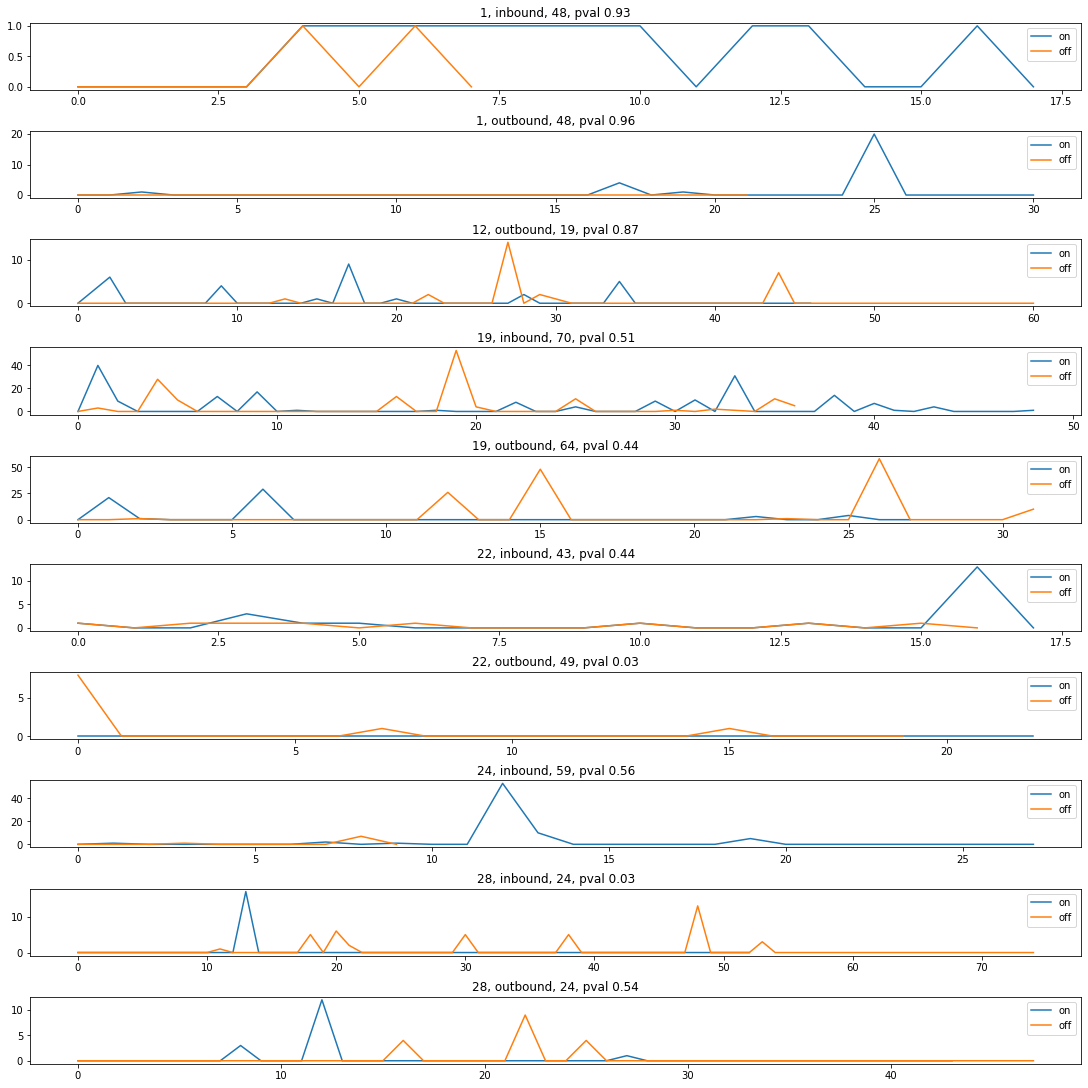

In [15]:
rejected_idxs_manw, num_errs = mannwhitney(triplogs_on, triplogs_off)
print("number of errors:", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_manw[:10])

In [16]:
rejected_idxs_stud, num_errs = student(triplogs_on, triplogs_off)
print("number of errors:", num_errs)

0 of 52 rejected 0.0
number of errors: 0


In [17]:
rejected_idxs_manw_new = [x[1] for x in rejected_idxs_manw]
rejected_idxs_stud_new = [x[1] for x in rejected_idxs_stud]
set(rejected_idxs_manw_new).intersection(rejected_idxs_stud_new)

set()

## With hourly separation

In [18]:
triplogs_on = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOn'].groupby(['routename', 'direction','stops', "starthour"])['countlate'].apply(list)
triplogs_on = triplogs_on.apply(lambda x: np.array(x))

In [19]:
triplogs_off = triplogs_df_good[triplogs_df_good.tspmode == 'alwaysOff'].groupby(['routename', 'direction','stops', "starthour"])['countlate'].apply(list)
triplogs_off = triplogs_off.apply(lambda x: np.array(x))

In [20]:
# drop less that 3 obserations
triplogs_off_idx = triplogs_off.apply(lambda x: len(x) > 3)
triplogs_off = triplogs_off[triplogs_off_idx]
print(triplogs_off.shape)

triplogs_on_idx = triplogs_on.apply(lambda x: len(x) > 3)
triplogs_on = triplogs_on[triplogs_on_idx]
print(triplogs_on.shape)

(445,)
(257,)


127 of 257 rejected 0.49416342412451364
number of errors 61


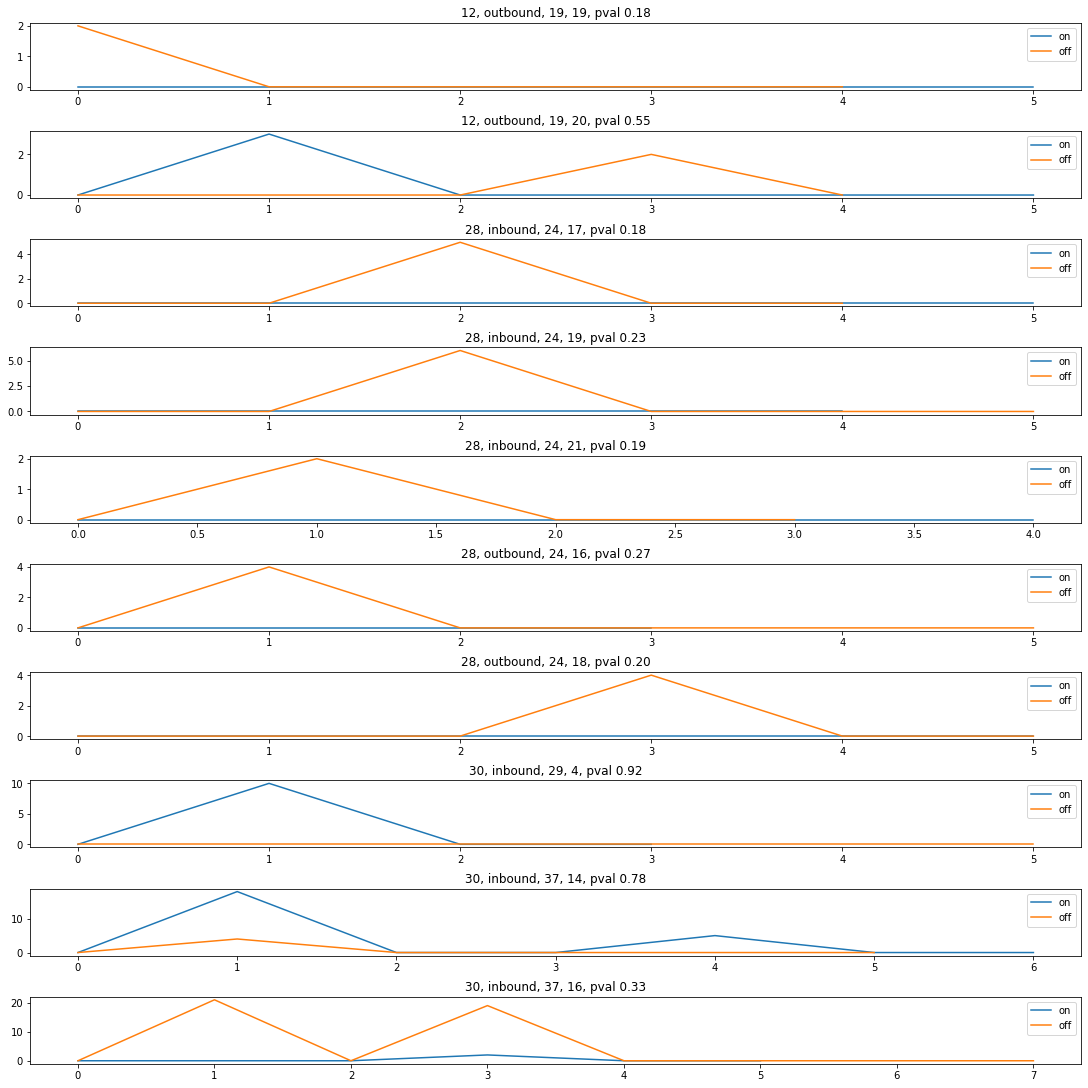

In [21]:
rejected_idxs_man, num_errs = mannwhitney(triplogs_on, triplogs_off)
print("number of errors", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_man[:10])

2 of 257 rejected 0.007782101167315175
number of errors 0


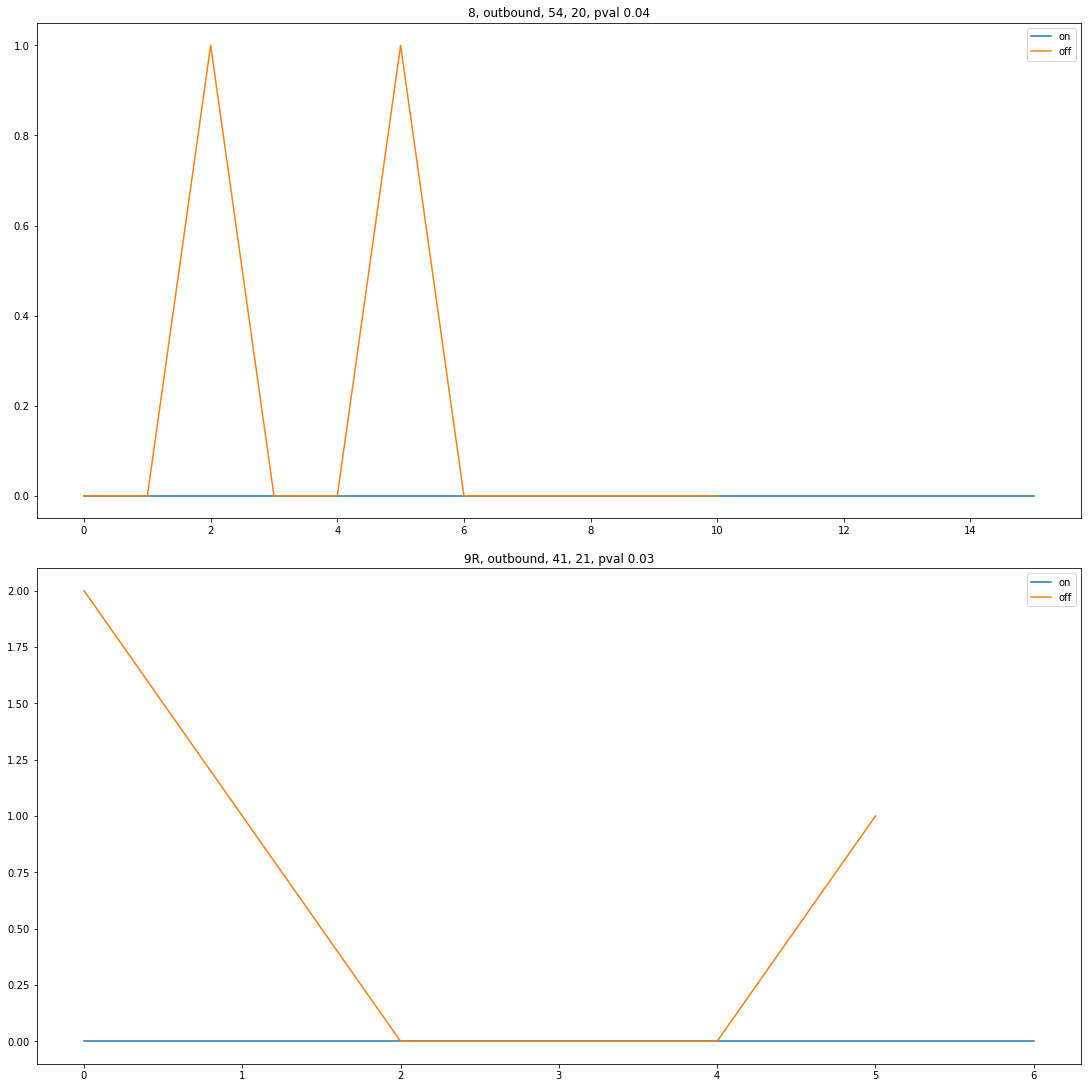

In [22]:
rejected_idxs_stud, num_errs = student(triplogs_on, triplogs_off)
print("number of errors", num_errs)
plot_trips(triplogs_on, triplogs_off, rejected_idxs_stud[:10])

In [23]:
rejected_idxs_manw_new = [x[1] for x in rejected_idxs_manw]
rejected_idxs_stud_new = [x[1] for x in rejected_idxs_stud]
set(rejected_idxs_manw_new).intersection(rejected_idxs_stud_new)

set()